In [1]:
# if this line is not separated from the line below this cell has to be executed twice
%matplotlib notebook 
#%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%time
# import pyicon as pyic  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import xarray as xr

import multiprocessing
# from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
import dask
from dask.utils import format_bytes
from dask.distributed import Client, LocalCluster, progress # Libaray to orchestrate distributed resources
from dask_jobqueue import SLURMCluster
import datetime
import pyicon as pyic
import datetime

calc
tb
xarray
done xarray
IconData
plotting
view
calc
tb
IconData
plotting
view
quickplots
quickplots
CPU times: user 2.2 s, sys: 1.82 s, total: 4.03 s
Wall time: 26.7 s


In [3]:
def myout(text):
    print(f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}: {text}')
    return

In [4]:
# set the dask temp dir to be on scratch (not sure if necessary but better save than sorry)
dask.config.set(temporary_directory='/scratch/m/m300602/tmp/dask/')

Define a slurm script that will be used to reserve a certain amount of cores for our computations.

In [5]:
# Set some user specific variables
account_name = 'bm1102' # Account that is going to be 'charged' fore the computation
# queue = 'compute2' # Name of the partition we want to use
queue = 'gpu' # Name of the partition we want to use
job_name = 'dask_pp' # Job name that is submitted via sbatch
memory = "100GiB" # Max memory per node that is going to be used - this depends on the partition
cores = 24 # Max number of cores per task that are reserved - also partition dependend
walltime = '4:00:00' # Walltime - also partition dependent

# scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
# dask_tmp_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
dask_tmp_dir = '/scratch/m/m300602/tmp/dask/slurm_dask/'
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       project=account_name,
                       walltime=walltime,
                       queue=queue,
                       name=job_name,
                       #scheduler_options={'dashboard_address': ':12435'},
                       local_directory=dask_tmp_dir,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_tmp_dir}',
                                  f'--begin=now',
                                  f'--output={dask_tmp_dir}/LOG_cluster.%j.o',
                                  f'--output={dask_tmp_dir}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p gpu
#SBATCH -A bm1102
#SBATCH -n 1
#SBATCH --cpus-per-task=24
#SBATCH --mem=100G
#SBATCH -t 4:00:00
#SBATCH -J dask_pp
#SBATCH -D /scratch/m/m300602/tmp/dask/slurm_dask/
#SBATCH --begin=now
#SBATCH --output=/scratch/m/m300602/tmp/dask/slurm_dask//LOG_cluster.%j.o
#SBATCH --output=/scratch/m/m300602/tmp/dask/slurm_dask//LOG_cluster.%j.o

JOB_ID=${SLURM_JOB_ID%;*}

/home/mpim/m300602/miniconda2/envs/pyicon_py38_exp/bin/python -m distributed.cli.dask_worker tcp://10.50.32.30:41850 --nthreads 24 --memory-limit 100.00GiB --name name --nanny --death-timeout 60 --local-directory /scratch/m/m300602/tmp/dask/slurm_dask/ --interface ib0



Start the cluster, eventually scale up which means the above slurm script is submitted twice.

In [6]:
# cluster.scale(jobs=2)  # good performance with compute2
cluster.scale(jobs=2)
cluster

Check whether jobs are running and whether we are ready to continue.

In [7]:
! squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          30755445       gpu  dask_pp  m300602 PD       0:00      1 (None)
          30755446       gpu  dask_pp  m300602 PD       0:00      1 (None)


In [8]:
client = Client(cluster)

In [9]:
client
# client.shutdown() # to shutdown an old client

<Client: 'tcp://10.50.32.30:41850' processes=0 threads=0, memory=0 B>

Some options to open netcdf files. Important: Chunks define the parallelization. E.g. `time=1` means only one time slice is read into memory. Strategy here: use chunks in depth and time but do not parallelize in horizontal direction since 2D field fits into memory.

In [10]:
mfdset_kwargs = dict(combine='nested', concat_dim='time', 
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                    )

In [1]:
# path_scratch = '/scratch/m/m300602/dymwin/'
path_scratch = '/mnt/lustre02/work/bm1102/m300602/proj_dw/pp/'
fpatho = f'{path_scratch}/pp_dymwin_interp_zon_ave.nc'

In [12]:
fpath_fx = '/pool/data/ICON/oes/input/r0004/OceanOnly_IcosSymmetric_4932m_rotatedZ37d_modified_srtm30_1min/dyamond-winter_R2B9L128_fx.nc'
ds_fx = xr.open_mfdataset(fpath_fx, **mfdset_kwargs, chunks=dict(time=1, depth=1, depth_2=1))
depth = ds_fx.depth.compute().data

In [13]:
fpath_ckdtree = '/home/mpim/m300602/work/icon/grids/r2b9_oce_r0004/ckdtree/rectgrids/r2b9_oce_r0004_res0.30_180W-180E_90S-90N.npz'
ddnpz = np.load(fpath_ckdtree)
lon, lat = ddnpz['lon'], ddnpz['lat']

In [14]:
## does not seem to work

# %%time
# ds_icon = xr.Dataset(coords=dict(month=np.arange(1,13), depth=depth, lat=lat, lon=lon))
# for var in ['to', 'so', 'u', 'v']:
#     print(var)
#     fname = f'pp_dymwin_time_ave_*.nc'
#     fpath_data = f'/scratch/m/m300602/tmp/dask/slurm_dask/nc/{fname}'
#     print(fpath_data)
#     ds = xr.open_mfdataset(fpath_data, **mfdset_kwargs, chunks=dict(time=1, depth=1))
#     lon, lat, data = pyic.interp_to_rectgrid(ds[var], fpath_ckdtree)
#     ds_icon[f'{var}i'] = xr.DataArray(data, dims=['month', 'depth', 'lat', 'lon'])
# print(f'Saving {fpatho}')
# ds_icon.to_netcdf(fpatho)

In [22]:
fpath_ref = f'{path_scratch}/dymwin_bias_plots_interp_ref.nc'
print(f'Loading {fpath_ref}')
ds_ref = xr.open_dataset(fpath_ref, chunks=dict(depth=1, time=1))

Loading /scratch/m/m300602/dymwin//dymwin_bias_plots_interp_ref.nc


In [16]:
fpath_icon = f'{path_scratch}/dymwin_bias_plots_interp_icon.nc'
print(f'Loading {fpath_icon}')
ds_icon = xr.open_dataset(fpath_icon, chunks=dict(depth=1, time=1))

Loading /scratch/m/m300602/dymwin//dymwin_bias_plots_interp_icon.nc


In [19]:
ds_icon

<xarray.Dataset>
Dimensions:  (depth: 128, lat: 600, lon: 1200, month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * depth    (depth) float64 3.5 8.0 10.5 13.5 ... 4.323e+03 4.734e+03 5.185e+03
  * lat      (lat) float64 -90.0 -89.7 -89.4 -89.1 -88.8 ... 88.8 89.1 89.4 89.7
  * lon      (lon) float64 -180.0 -179.7 -179.4 -179.1 ... 179.1 179.4 179.7
Data variables:
    toi      (month, depth, lat, lon) float64 dask.array<chunksize=(12, 1, 600, 1200), meta=np.ndarray>
    soi      (month, depth, lat, lon) float64 dask.array<chunksize=(12, 1, 600, 1200), meta=np.ndarray>
    ui       (month, depth, lat, lon) float64 dask.array<chunksize=(12, 1, 600, 1200), meta=np.ndarray>
    vi       (month, depth, lat, lon) float64 dask.array<chunksize=(12, 1, 600, 1200), meta=np.ndarray>

In [26]:
%%time
lon, lat, basin_ci = pyic.interp_to_rectgrid(ds_fx.basin_c, fpath_ckdtree=fpath_ckdtree)
ds_icon['basin_ci'] = xr.DataArray(basin_ci, dims=['lat', 'lon'])

CPU times: user 431 ms, sys: 570 ms, total: 1 s
Wall time: 4.06 s


In [27]:
%%time
myout('bias')
ds_icon['tbias'] = ds_icon['toi'] - ds_ref['to_ref']
ds_icon['sbias'] = ds_icon['soi'] - ds_ref['so_ref']

myout('gzave')
ds_icon['tbias_gzave'] = ds_icon['tbias'].mean(dim='lon')
ds_icon['sbias_gzave'] = ds_icon['sbias'].mean(dim='lon')

ds_icon['to_gzave'] = ds_icon['toi'].mean(dim='lon')
ds_icon['so_gzave'] = ds_icon['soi'].mean(dim='lon')
ds_icon['uo_gzave'] = ds_icon['ui'].mean(dim='lon')

myout('azave')
data = ds_icon['tbias'].where(basin_ci!=1)
data = data.mean(dim='lon').compute()
ds_icon['tbias_zave'] = data

data = ds_icon['sbias'].where(basin_ci!=1)
data = data.mean(dim='lon').compute()
ds_icon['sbias_zave'] = data

myout('ipzave')
data = ds_icon['tbias'].where((basin_ci!=3)&(basin_ci!=7))
data = data.mean(dim='lon').compute()
ds_icon['tbias_zave'] = data

data = ds_icon['sbias'].where((basin_ci!=3)&(basin_ci!=7))
data = data.mean(dim='lon').compute()
ds_icon['sbias_zave'] = data

2021-06-17 19:09:29: bias
2021-06-17 19:09:29: gzave
2021-06-17 19:09:29: azave
2021-06-17 19:10:52: ipzave
CPU times: user 20.5 s, sys: 1.46 s, total: 22 s
Wall time: 2min 4s


In [28]:
%%time
print(f'Saving {fpatho}')
ds_icon.to_netcdf(fpatho)

Saving /scratch/m/m300602/dymwin//pp_dymwin_interp_zon_ave.nc
CPU times: user 1min 39s, sys: 6.48 s, total: 1min 45s
Wall time: 12min 51s


In [30]:
!du -sh /scratch/m/m300602/dymwin//pp_dymwin_interp_zon_ave.nc

50G	/scratch/m/m300602/dymwin//pp_dymwin_interp_zon_ave.nc


In [29]:
ds_icon

<xarray.Dataset>
Dimensions:      (depth: 128, lat: 600, lon: 1200, month: 12)
Coordinates:
  * lat          (lat) float64 -90.0 -89.7 -89.4 -89.1 ... 88.8 89.1 89.4 89.7
  * lon          (lon) float64 -180.0 -179.7 -179.4 -179.1 ... 179.1 179.4 179.7
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * depth        (depth) float64 3.5 8.0 10.5 ... 4.323e+03 4.734e+03 5.185e+03
Data variables: (12/14)
    toi          (month, depth, lat, lon) float64 dask.array<chunksize=(12, 1, 600, 1200), meta=np.ndarray>
    soi          (month, depth, lat, lon) float64 dask.array<chunksize=(12, 1, 600, 1200), meta=np.ndarray>
    ui           (month, depth, lat, lon) float64 dask.array<chunksize=(12, 1, 600, 1200), meta=np.ndarray>
    vi           (month, depth, lat, lon) float64 dask.array<chunksize=(12, 1, 600, 1200), meta=np.ndarray>
    basin_ci     (lat, lon) float32 nan nan nan nan nan ... 1.0 1.0 1.0 1.0 1.0
    tbias        (month, depth, lat, lon) float64 dask.array<chunksize=(12, 1, 600, 1200), meta=np.ndarray>
    ...           ...
    sbias_gzave  (month, depth, lat) float64 dask.array<chunksize=(12, 1, 600), meta=np.ndarray>
    to_gzave     (month, depth, lat) float64 dask.array<chunksize=(12, 1, 600), meta=np.ndarray>
    so_gzave     (month, depth, lat) float64 dask.array<chunksize=(12, 1, 600), meta=np.ndarray>
    uo_gzave     (month, depth, lat) float64 dask.array<chunksize=(12, 1, 600), meta=np.ndarray>
    tbias_zave   (month, depth, lat) float64 nan nan nan nan ... nan nan nan nan
    sbias_zave   (month, depth, lat) float64 nan nan nan nan ... nan nan nan nan

<IPython.core.display.Javascript object>


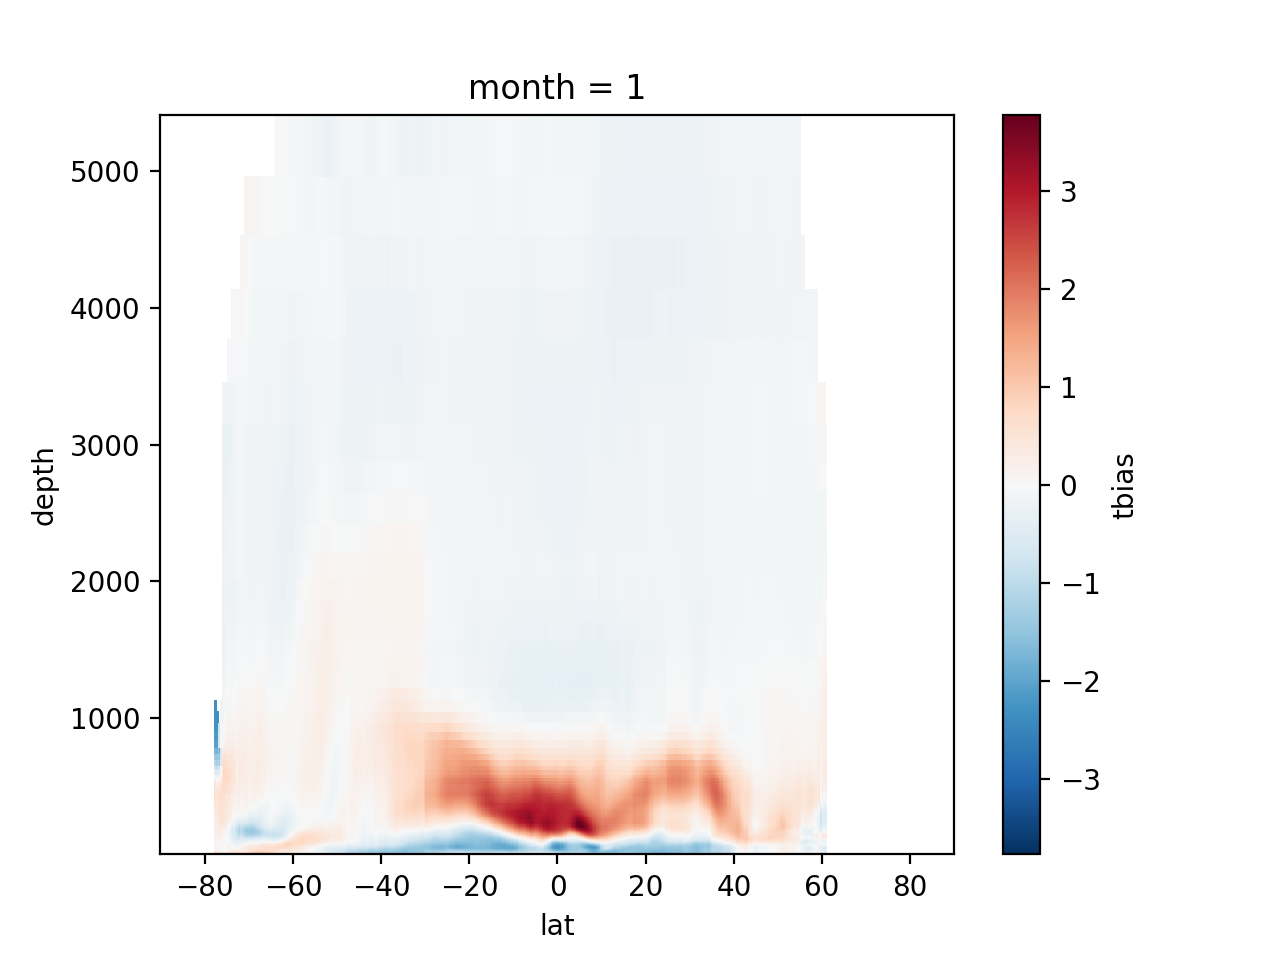

In [50]:
data[0,:,:].plot()